### Import Libraries

In [27]:
import pandas as pd 
import numpy as np
import math
import os
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")
%matplotlib inline

<!--  -->

### Sample Data

In [28]:
# Storing into Dataframe
file_path = os.getcwd()+"\\Data\\tennis.csv"
df_tennis_data = pd.read_csv(file_path, usecols=["outlook","temp","humidity","windy","play"])

<!--  -->

### Descriptive Analysis

In [29]:
print(df_tennis_data.head(2),"\n")
print("Columns: {}\n".format(df_tennis_data.columns.to_list()))
print("Data shape: {}\n".format(df_tennis_data.shape))
print(df_tennis_data.info(),"\n")
print("Missing Records per Column:")
print("--"*10)
print(df_tennis_data.isnull().sum()) # Missing values per Column
df_tennis_data.describe(include="all") # Stats

  outlook temp humidity  windy play
0   sunny  hot     high  False   no
1   sunny  hot     high   True   no 

Columns: ['outlook', 'temp', 'humidity', 'windy', 'play']

Data shape: (14, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   outlook   14 non-null     object
 1   temp      14 non-null     object
 2   humidity  14 non-null     object
 3   windy     14 non-null     bool  
 4   play      14 non-null     object
dtypes: bool(1), object(4)
memory usage: 594.0+ bytes
None 

Missing Records per Column:
--------------------
outlook     0
temp        0
humidity    0
windy       0
play        0
dtype: int64


,outlook,temp,humidity,windy,play
count,14,14,14,14,14
unique,3,3,2,2,2
top,sunny,mild,high,False,yes
freq,5,6,7,8,9


In [30]:
df_tennis_data

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


<!--  -->

### EDA

- Play Data Distribution (Counts)

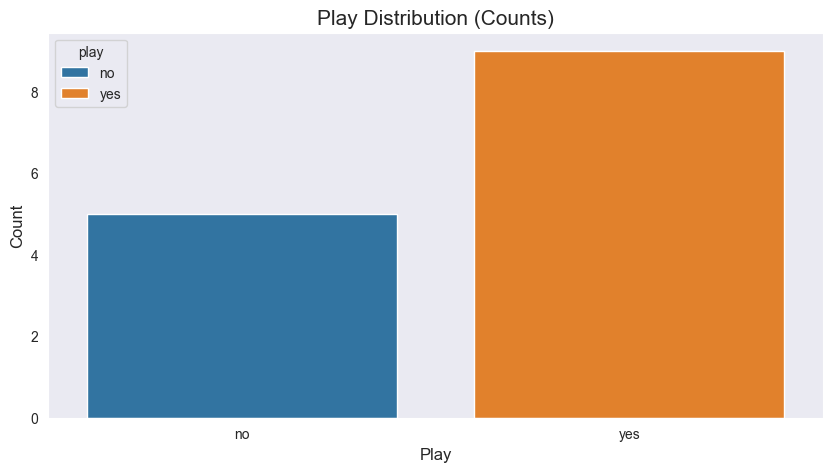

In [31]:
df_counts = df_tennis_data.groupby("play")["play"].value_counts().reset_index()

# Plot
sns.set_style("dark")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
sns.barplot(x="play", y="count", data=df_counts, hue="play", legend=True, ax=axes)
axes.set_title("Play Distribution (Counts)", size=15)
axes.set_xlabel("Play", size=12)
axes.set_ylabel("Count", size=12)
plt.show()

- Outlook Data Distribution (Counts)

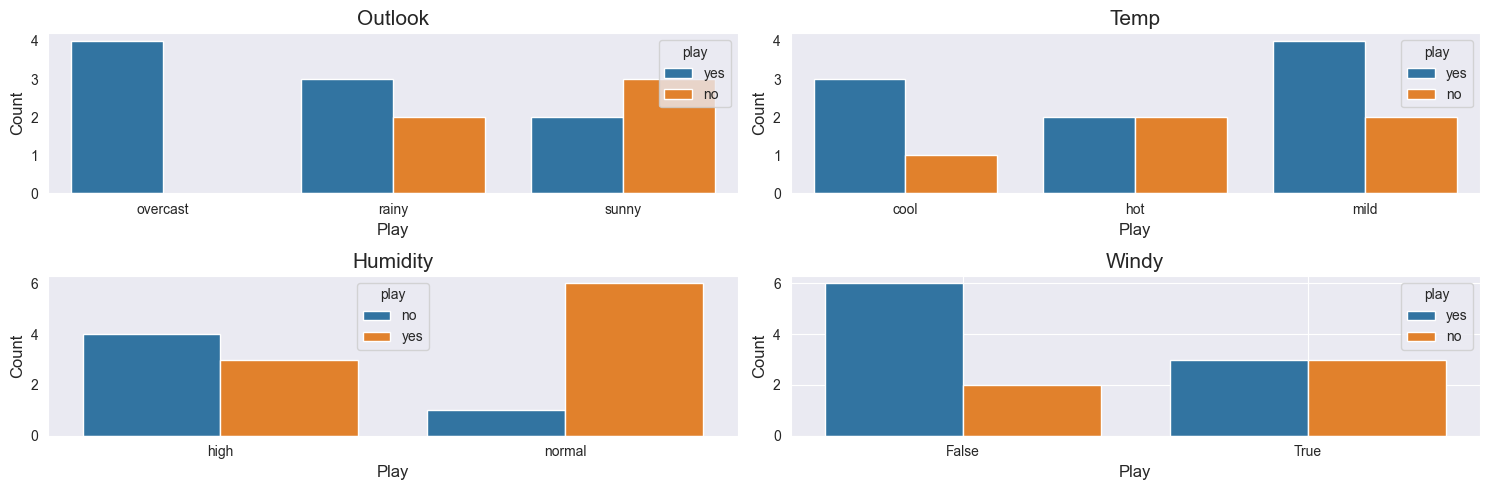

In [32]:
# Plot
sns.set_style("dark")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,5))

df_counts = df_tennis_data.groupby("outlook")["play"].value_counts().reset_index()
sns.barplot(x="outlook", y="count", data=df_counts, hue="play", legend=True, ax=axes[0][0])
axes[0][0].set_title("Outlook", size=15)
axes[0][0].set_xlabel("Play", size=12)
axes[0][0].set_ylabel("Count", size=12)

df_counts = df_tennis_data.groupby("temp")["play"].value_counts().reset_index()
sns.barplot(x="temp", y="count", data=df_counts, hue="play", legend=True, ax=axes[0][1])
axes[0][1].set_title("Temp", size=15)
axes[0][1].set_xlabel("Play", size=12)
axes[0][1].set_ylabel("Count", size=12)

df_counts = df_tennis_data.groupby("humidity")["play"].value_counts().reset_index()
sns.barplot(x="humidity", y="count", data=df_counts, hue="play", legend=True, ax=axes[1][0])
axes[1][0].set_title("Humidity", size=15)
axes[1][0].set_xlabel("Play", size=12)
axes[1][0].set_ylabel("Count", size=12)

df_counts = df_tennis_data.groupby("windy")["play"].value_counts().reset_index()
sns.barplot(x="windy", y="count", data=df_counts, hue="play", legend=True, ax=axes[1][1])
axes[1][1].set_title("Windy", size=15)
axes[1][1].set_xlabel("Play", size=12)
axes[1][1].set_ylabel("Count", size=12)

plt.grid(True)
plt.tight_layout()
plt.show()

<!--  -->

### Entropy Calculation: On Whole Target Classes

In [35]:
def calculate_entropy(df):
    print("--"*15)
    print("Entropy")
    print("--"*15)
    # Store target class counts
    class_counts = {}
    for index, row in df.iterrows():
        target_class = row["play"]
        class_counts[target_class] = class_counts.get(target_class, 0) + 1 # , 0 => handles empty/null values
    total_counts = len(df)
    print("     >> class counts --> ", class_counts)
    print("     >> total counts --> ", total_counts)

    # Calculate target class probabilities
    class_probabilities = {cls: round(count / total_counts,2) for cls, count in class_counts.items()}
    print("     >> class probabilities --> ", class_probabilities,"\n")

    # Calculate Entropy
    entropy = 0
    for p_value in class_probabilities.values(): # Iterate through each class probability value
        if p_value > 0:
            # Entropy = -Σ [p(i) * log2(p(i))]
            entropy -= p_value * math.log2(p_value)
    return round(entropy, 2)

- Total Entropy calculation on all Target classes

In [36]:
entropy_value = calculate_entropy(df_tennis_data)
print("entropy value -->", entropy_value)

------------------------------
Entropy
------------------------------
     >> class counts -->  {'no': 5, 'yes': 9}
     >> total counts -->  14
     >> class probabilities -->  {'no': 0.36, 'yes': 0.64} 

entropy value --> 0.94


<!--  -->

### Information Gain Calculation: On One Attribute ex:- [outlook]

In [37]:
def calculate_information_gain(df, attribute):
    # Calculate initial entropy of the entire dataset
    entropy_value = calculate_entropy(df)
    print("entropy value -->", entropy_value)

    # Store information gain for each attribute
    attribute_information_gain = {}

    # Iterate through unique values of given attribute
    attribute_unique_values = set([row[attribute] for index, row in df.iterrows()])
    print("attribute unique values -->", attribute_unique_values, "\n")
    for value in attribute_unique_values:
        
        print("  *"*15)
        print("    >> attribute unique value -->", value)
        print("  *"*15)
        # Subset data based on attribute unique value
        df_subset = df[df[attribute] == value]

        # Calculate entropy for this subset data
        subset_entropy_value = calculate_entropy(df_subset)
        print("    >> subset entropy value -->", subset_entropy_value)

        # Proportion of this subset based on whole data
        subset_proportion = round(len(df_subset) / len(df), 2)
        print("    >> subset proportion -->", subset_proportion)

        # Information gain for given attribute unique value
        # Information Gain(S, A) = Entropy(S) - Σ [ |S_v| / |S| * Entropy(S_v) ]
        attribute_information_gain[value] = round((subset_proportion * subset_entropy_value),2)
    
    # Attribute final information gain of all unique values
    print("    >> attribute information gain -->", attribute_information_gain, "\n")
    total_information_gain = round(entropy_value - (sum(attribute_information_gain.values())), 2)

    return total_information_gain

- outlook

In [38]:
information_gain = calculate_information_gain(df_tennis_data, "outlook")
print(f"{"outlook"} attribute information gain --> ", information_gain)

------------------------------
Entropy
------------------------------
     >> class counts -->  {'no': 5, 'yes': 9}
     >> total counts -->  14
     >> class probabilities -->  {'no': 0.36, 'yes': 0.64} 

entropy value --> 0.94
attribute unique values --> {'overcast', 'rainy', 'sunny'} 

  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *
    >> attribute unique value --> overcast
  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *
------------------------------
Entropy
------------------------------
     >> class counts -->  {'yes': 4}
     >> total counts -->  4
     >> class probabilities -->  {'yes': 1.0} 

    >> subset entropy value --> 0.0
    >> subset proportion --> 0.29
  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *
    >> attribute unique value --> rainy
  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *
------------------------------
Entropy
------------------------------
     >> class counts -->  {'yes': 3, 'no': 2}
     >> total counts -->  5
     >> class probabilities -->  {'yes': 0.6, 

- temp

In [39]:
information_gain = calculate_information_gain(df_tennis_data, "temp")
print(f"{"temp"} attribute information gain --> ", information_gain)

------------------------------
Entropy
------------------------------
     >> class counts -->  {'no': 5, 'yes': 9}
     >> total counts -->  14
     >> class probabilities -->  {'no': 0.36, 'yes': 0.64} 

entropy value --> 0.94
attribute unique values --> {'cool', 'mild', 'hot'} 

  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *
    >> attribute unique value --> cool
  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *
------------------------------
Entropy
------------------------------
     >> class counts -->  {'yes': 3, 'no': 1}
     >> total counts -->  4
     >> class probabilities -->  {'yes': 0.75, 'no': 0.25} 

    >> subset entropy value --> 0.81
    >> subset proportion --> 0.29
  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *
    >> attribute unique value --> mild
  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *
------------------------------
Entropy
------------------------------
     >> class counts -->  {'yes': 4, 'no': 2}
     >> total counts -->  6
     >> class probabilities -->  {'

- humidity

In [40]:
information_gain = calculate_information_gain(df_tennis_data, "humidity")
print(f"{"humidity"} attribute information gain --> ", information_gain)

------------------------------
Entropy
------------------------------
     >> class counts -->  {'no': 5, 'yes': 9}
     >> total counts -->  14
     >> class probabilities -->  {'no': 0.36, 'yes': 0.64} 

entropy value --> 0.94
attribute unique values --> {'normal', 'high'} 

  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *
    >> attribute unique value --> normal
  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *
------------------------------
Entropy
------------------------------
     >> class counts -->  {'yes': 6, 'no': 1}
     >> total counts -->  7
     >> class probabilities -->  {'yes': 0.86, 'no': 0.14} 

    >> subset entropy value --> 0.58
    >> subset proportion --> 0.5
  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *
    >> attribute unique value --> high
  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *
------------------------------
Entropy
------------------------------
     >> class counts -->  {'no': 4, 'yes': 3}
     >> total counts -->  7
     >> class probabilities -->  {'no':

- windy

In [41]:
information_gain = calculate_information_gain(df_tennis_data, "windy")
print(f"{"windy"} attribute information gain --> ", information_gain)

------------------------------
Entropy
------------------------------
     >> class counts -->  {'no': 5, 'yes': 9}
     >> total counts -->  14
     >> class probabilities -->  {'no': 0.36, 'yes': 0.64} 

entropy value --> 0.94
attribute unique values --> {False, True} 

  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *
    >> attribute unique value --> False
  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *
------------------------------
Entropy
------------------------------
     >> class counts -->  {'no': 2, 'yes': 6}
     >> total counts -->  8
     >> class probabilities -->  {'no': 0.25, 'yes': 0.75} 

    >> subset entropy value --> 0.81
    >> subset proportion --> 0.57
  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *
    >> attribute unique value --> True
  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *
------------------------------
Entropy
------------------------------
     >> class counts -->  {'no': 3, 'yes': 3}
     >> total counts -->  6
     >> class probabilities -->  {'no': 0.5,

<!--  -->

Observation

Few reasons why a decision tree built from scratch in Python might not produce the same results as scikit-learn's DecisionTreeClassifier

**Splitting Criteria**

- By default, scikit-learn's DecisionTreeClassifier uses the Gini impurity or information gain for selecting the best feature split. We have used information gain and also selected information gain in sklearn model

**Randomization**

- Some scikit-learn decision tree implementations (e.g., random_state parameter) introduce randomness during splitting. This can lead to slightly different trees even with the same data, especially for ties between features with similar information gain.

**Data Handling**

- Missing Values: Scikit-learn might have specific strategies for handling missing values (e.g., ignoring rows, using imputation techniques). Your manual implementation might not account for missing values, leading to discrepancies.
- Feature Scaling: Scikit-learn might internally scale features if necessary. If your manual implementation doesn't handle scaling, differences in feature values can affect the splitting decisions.

**Categorical Features**
- Scikit-learn: Assumes numerical features for splitting. Categorical features need encoding (e.g., one-hot encoding) before using them in the decision tree.
- Manual Implementation: You might need to explicitly handle categorical features by encoding them into numerical representations before using them for splitting.

Key point

Our focus here was mainly to show how Entropy and Information Gain is calculated, surely SKlearn library uses advanced methods/strategy to do this, hence our manual implementation and sklearn doesnt matches about entropy value and spliting methodology i..e., Not equal attributes subset split of variable Ex:- We expect from manual implementation i.e., First split Humidity -> high, normal subsets as sub childs, but sklearn only select Humidity_High as first split and after some splits then Humidity_Normal, don't know exact reason why like this, even after many blogs reading. 

<!--  -->

### Categorical to Numerical Features Creation

- Dummy Variables Creation

In [42]:
df_tennis_data.columns.tolist()[:-1]

['outlook', 'temp', 'humidity', 'windy']

In [43]:
# Create dummy vars
df_dummy = pd.get_dummies(data=df_tennis_data, columns=df_tennis_data.columns.tolist()[:-1])
df_dummy

,play,outlook_overcast,outlook_rainy,outlook_sunny,temp_cool,temp_hot,temp_mild,humidity_high,humidity_normal,windy_False,windy_True
0,no,False,False,True,False,True,False,True,False,True,False
1,no,False,False,True,False,True,False,True,False,False,True
2,yes,True,False,False,False,True,False,True,False,True,False
3,yes,False,True,False,False,False,True,True,False,True,False
4,yes,False,True,False,True,False,False,False,True,True,False
5,no,False,True,False,True,False,False,False,True,False,True
6,yes,True,False,False,True,False,False,False,True,False,True
7,no,False,False,True,False,False,True,True,False,True,False
8,yes,False,False,True,True,False,False,False,True,True,False
9,yes,False,True,False,False,False,True,False,True,True,False


<!--  -->

### Model Training

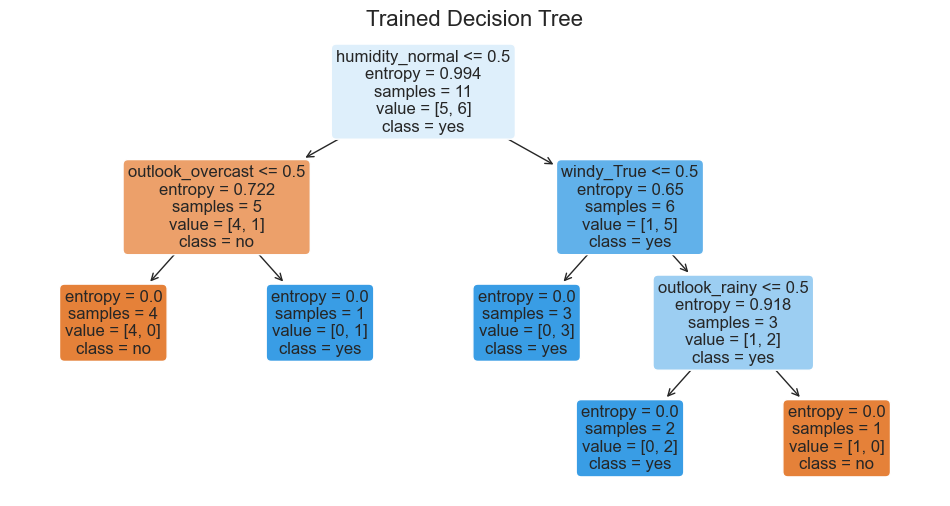

In [72]:
X = df_dummy.drop('play', axis=1)
y = df_dummy["play"]

# Train and Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

# Train Model
dtree = DecisionTreeClassifier(criterion="entropy", random_state=0)
# dtree = DecisionTreeClassifier(max_depth=2, criterion="entropy", random_state=0)
# dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

# Trained Decision Tree Visual
fig = plt.figure(figsize=(12, 6))
sns.set_style('dark')
plot_tree(dtree, 
            feature_names=X_train.columns.tolist(), 
            fontsize=12, 
            filled=True, 
            rounded=True,
            class_names=['no', 'yes'] # This order displays "no" on the right side of the tree and "yes" on the left side. 
            )
plt.title("Trained Decision Tree", size=16)
plt.show()

Observation

> * Node colour get assigned as per each class label. i.e., orange - not play class, blue - play class. 
> * Higher the class label counts and then colour would be dominating class label one for node.
> * more pure/dominating node with labels more thicker the colour
> * Node with same proportion of labels count, then by default colour of the node would be white.

<!--  -->

### Decision Tree Evaluation

- First Split --> Humidity Normal

In [47]:
x_train_index_list = X_train.index.tolist()
x_train_index_list

[13, 10, 5, 0, 4, 8, 9, 7, 6, 1, 11]

In [55]:
df_tennis_data.loc[x_train_index_list,:][df_tennis_data["humidity"]=="normal"].groupby(["play"])["play"].value_counts().reset_index() # no-1, yes-5 --> very high certainity

,play,count
0,no,1
1,yes,5


In [69]:
# humidity
# df_tennis_data.loc[x_train_index_list,:][df_tennis_data["humidity"]=="high"].groupby(["play"])["play"].value_counts().reset_index() # no-4, yes-1 --> very high certainity

# outlook
# df_tennis_data.loc[x_train_index_list,:][df_tennis_data["outlook"]=="sunny"].groupby(["play"])["play"].value_counts().reset_index() # no-3, yes-2 --> high uncertainity
# df_tennis_data.loc[x_train_index_list,:][df_tennis_data["outlook"]=="overcast"].groupby(["play"])["play"].value_counts().reset_index() # yes-2 --> very high certainity
# df_tennis_data.loc[x_train_index_list,:][df_tennis_data["outlook"]=="rainy"].groupby(["play"])["play"].value_counts().reset_index() # no-2, yes-2 --> very high uncertainity

# temp
# df_tennis_data.loc[x_train_index_list,:][df_tennis_data["temp"]=="hot"].groupby(["play"])["play"].value_counts().reset_index() # no-2 --> very high certainity
# df_tennis_data.loc[x_train_index_list,:][df_tennis_data["temp"]=="mild"].groupby(["play"])["play"].value_counts().reset_index() # no-2, yes-3 --> high uncertainity
# df_tennis_data.loc[x_train_index_list,:][df_tennis_data["temp"]=="cool"].groupby(["play"])["play"].value_counts().reset_index() # no-1, yes-3 --> low uncertainity

# windy
# df_tennis_data.loc[x_train_index_list,:][df_tennis_data["windy"]==False].groupby(["play"])["play"].value_counts().reset_index() # no-2, yes-3 --> high uncertainity
# df_tennis_data.loc[x_train_index_list,:][df_tennis_data["windy"]==True].groupby(["play"])["play"].value_counts().reset_index() # no-3, yes-3 --> very high uncertainity

,play,count
0,no,3
1,yes,3


Observation

- During initial split, on whole data level, may be ["humidity"]=="normal" has the lowest entropy (very high certainity i.e., most counts belong to one category) that is why this attribute subset was selected to split. 

<!--  -->

### Model Evaluation
> * Accuracy = (TP + TN) / (Total number of observation)
> * Accuracy = The number of correct predictions made divided by the total number of predictions made.

In [73]:
x_test_index_list = X_test.index.to_list()
x_test_index_list

[12, 2, 3]

In [74]:
df_tennis_data.loc[x_test_index_list,:]

,outlook,temp,humidity,windy,play
12,overcast,hot,normal,False,yes
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes


In [82]:
y_pred = dtree.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
count_missclassified = sum(y_test != y_pred)

print("Accuracy: {:.2f}".format(accuracy))
print("Missclassied Counts: {0}".format(count_missclassified))

Accuracy: 0.67
Missclassied Counts: 1


- Confusion Matrix 

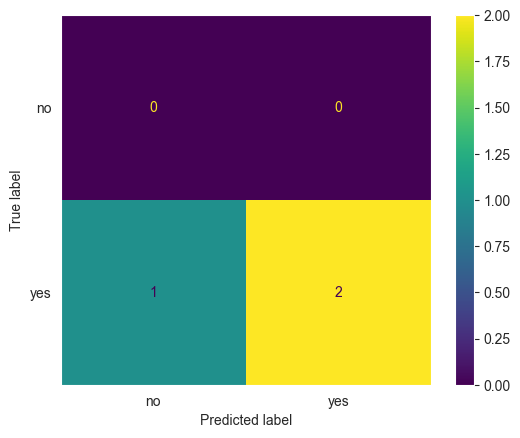

In [100]:
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
cm = metrics.confusion_matrix(y_test, y_pred, labels=dtree.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtree.classes_)
disp.plot()
plt.show()

Take Away Points :

> * Due to very less data points in X_train, our trained decision tree model doesn't performed well, even if we increased or decreased depth of the tree(i.e., hyperparameter).
> * Having more data in train dataset can make decision tree get trained with all cases covered and can make decisions on test data set cases accurately.